# Image Augmentation

1. Image resize

In [8]:
import cv2
import os

def resize_image_with_aspect_ratio_and_adjust_bboxes(image_path, bbox_path, output_folder, target_size=(100, 100)):
    # 이미지 읽기
    image = cv2.imread(image_path)
    h, w, _ = image.shape

    # 비율 유지하며 이미지 리사이즈
    scale = min(target_size[0] / h, target_size[1] / w)
    new_w = int(w * scale)
    new_h = int(h * scale)

    resized_image = cv2.resize(image, (new_w, new_h))

    # 패딩 추가하여 target_size에 맞추기
    delta_w = target_size[1] - new_w
    delta_h = target_size[0] - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]  # 검은색 패딩
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    # 바운딩 박스 읽기 (YOLO 형식)
    bboxes = []
    with open(bbox_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            label = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])

            # 기존 바운딩 박스 좌표를 리사이즈된 이미지에 맞게 조정
            new_x_center = (x_center * w * scale + left) / target_size[1]
            new_y_center = (y_center * h * scale + top) / target_size[0]
            new_width = width * scale * (w / target_size[1])  # 바운딩 박스 크기도 리사이즈
            new_height = height * scale * (h / target_size[0])

            bboxes.append([label, new_x_center, new_y_center, new_width, new_height])

    # 리사이즈된 이미지 저장 경로
    resized_image_path = os.path.join(output_folder, os.path.splitext(os.path.basename(image_path))[0] + '_resized.jpg')
    cv2.imwrite(resized_image_path, padded_image)

    # 조정된 바운딩 박스 저장 경로
    resized_bbox_path = os.path.join(output_folder, os.path.splitext(os.path.basename(bbox_path))[0] + '_resized.txt')
    with open(resized_bbox_path, 'w') as file:
        for bbox in bboxes:
            file.write(f"{bbox[0]} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f} {bbox[4]:.6f}\n")

    return resized_image_path, resized_bbox_path

# 예시 경로
data_path = 'cropped_images2/'  # 데이터가 있는 디렉토리 경로
output_folder = 'resized_images_100x100'  # 이미지를 저장할 경로

# 출력 폴더가 없으면 생성
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 데이터 디렉토리 내 모든 파일에 대해 처리
image_extensions = ('.jpg', '.jpeg', '.png')  # 지원하는 이미지 파일 확장자
for filename in os.listdir(data_path):
    if filename.endswith(image_extensions):
        image_path = os.path.join(data_path, filename)
        bbox_path = os.path.splitext(image_path)[0] + '.txt'  # 동일한 이름의 바운딩 박스 파일

        if os.path.exists(bbox_path):
            resize_image_with_aspect_ratio_and_adjust_bboxes(image_path, bbox_path, output_folder, target_size=(100, 100))
            print(f"Resized image and bounding box saved for {image_path}")
        else:
            print(f"Bounding box file not found for {image_path}")


Resized image and bounding box saved for cropped_images2/GasridTablet5mg(MosaprideCitrateHydrate)_crop_10_1.jpg
Resized image and bounding box saved for cropped_images2/GasridTablet5mg(MosaprideCitrateHydrate)_crop_10_0.jpg
Resized image and bounding box saved for cropped_images2/GasbetTablet5mg(MosaprideCitrateHydrate)_crop_7_0.jpg
Resized image and bounding box saved for cropped_images2/RosorodTablet10mg(RosuvastatinCalcium)_crop_13_0.jpg
Resized image and bounding box saved for cropped_images2/LipinonTablet80mg(AtorvastatinCalciumTrihydrate)_crop_11_1.jpg
Resized image and bounding box saved for cropped_images2/LipinonTablet80mg(AtorvastatinCalciumTrihydrate)_crop_11_0.jpg
Resized image and bounding box saved for cropped_images2/RosorodTablet10mg(RosuvastatinCalcium)_crop_13_1.jpg
Resized image and bounding box saved for cropped_images2/GasbetTablet5mg(MosaprideCitrateHydrate)_crop_7_1.jpg
Resized image and bounding box saved for cropped_images2/GasdialTablet50mg(DimethiconeMagnesiu

### Check Image bbox 

In [9]:
import cv2
import os

def draw_bboxes(image_path, bbox_path, output_path=None):
    # 이미지 읽기
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    
    # 바운딩 박스 읽기 (YOLO 형식)
    with open(bbox_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            label = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])
            
            # YOLO 형식의 바운딩 박스를 픽셀 좌표로 변환
            x1 = int((x_center - width / 2) * w)
            y1 = int((y_center - height / 2) * h)
            x2 = int((x_center + width / 2) * w)
            y2 = int((y_center + height / 2) * h)
            
            # 바운딩 박스 그리기 (색상은 랜덤으로 지정)
            color = (0, 255, 0)  # 초록색 바운딩 박스
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(image, f'Label: {label}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # 바운딩 박스가 그려진 이미지 저장 또는 출력
    if output_path:
        cv2.imwrite(output_path, image)
    else:
        cv2.imshow('Image with Bounding Boxes', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

# 사용 예시
image_path = 'resized_images_100x100/ApurtranTablet150mg(Irbesartan)_crop_0_0_resized.jpg'  # 실제 이미지 경로
bbox_path = 'resized_images_100x100/ApurtranTablet150mg(Irbesartan)_crop_0_0_resized.txt'    # 실제 YOLO 형식의 바운딩 박스 파일 경로
output_image_path = 'image_with_bboxes_test7.jpg'  # 결과 이미지를 저장할 경로

draw_bboxes(image_path, bbox_path, output_image_path)


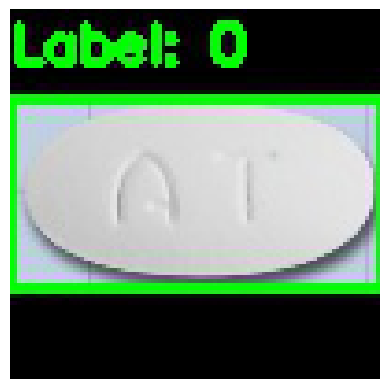

In [10]:
import cv2
import matplotlib.pyplot as plt

def show_image(image_path):
    # 이미지 읽기
    image = cv2.imread(image_path)
    
    # BGR을 RGB로 변환
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 이미지 표시
    plt.imshow(image_rgb)
    plt.axis('off')  # 축 숨기기
    plt.show()

# 예시 경로
image_path = 'image_with_bboxes_test7.jpg'  # 확인할 이미지 경로
show_image(image_path)


### Image Augmentation with Imgaug